In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_df="/kaggle/input/surface-crack/train"
test_df="/kaggle/input/surface-crack/test"
valid_df="/kaggle/input/surface-crack/valid"

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense


In [4]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)


In [5]:
train_generator = train_gen.flow_from_directory(train_df,
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                   )

validation_generator =  validation_gen.flow_from_directory(valid_df,
                                                                target_size=(224,224),
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                )  

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
res50 = Sequential()

res50.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
    ))

res50.add(Dense(2, activation='softmax'))

res50.layers[0].trainable = False 

res50.summary()

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)



2023-01-14 12:39:53.235506: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [7]:
from tensorflow.keras.layers import Flatten
from keras.models import Model


In [8]:

res50.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [10]:
filepath="we111ights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)
callbacks_list = [checkpoint, es]

In [11]:
history = res50.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    validation_steps=steps_per_epoch_validation,
    epochs=30,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callbacks_list,
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-14 12:39:55.819486: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
19/19 [==============================] - 49s 2s/step - loss: 0.2808 - accuracy: 0.8900 - val_loss: 0.1183 - val_accuracy: 0.9600

Epoch 00001: val_loss improved from inf to 0.11827, saving model to we111ights.best.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
19/19 [==============================] - 44s 2s/step - loss: 0.0875 - accuracy: 0.9733 - val_loss: 0.0676 - val_accuracy: 0.9750

Epoch 00002: val_loss improved from 0.11827 to 0.06764, saving model to we111ights.best.hdf5
Epoch 3/30
19/19 [==============================] - 44s 2s/step - loss: 0.0532 - accuracy: 0.9833 - val_loss: 0.0540 - val_accuracy: 0.9800

Epoch 00003: val_loss improved from 0.06764 to 0.05401, saving model to we111ights.best.hdf5
Epoch 4/30
19/19 [==============================] - 47s 2s/step - loss: 0.0413 - accuracy: 0.9883 - val_loss: 0.0459 - val_accuracy: 0.9850

Epoch 00004: val_loss improved from 0.05401 to 0.04588, saving model to we111ights.best.hdf5
Epoch 5/30
19/19 [==============================] - 44s 2s/step - loss: 0.0324 - accuracy: 0.9933 - val_loss: 0.0412 - val_accuracy: 0.9900

Epoch 00005: val_loss improved from 0.04588 to 0.04123, saving model to we111ights.best.hdf5
Epoch 6/30
19/19 [==============================] - 44s 2s/step 

In [12]:
fig = px.line( 
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
)

fig.show()

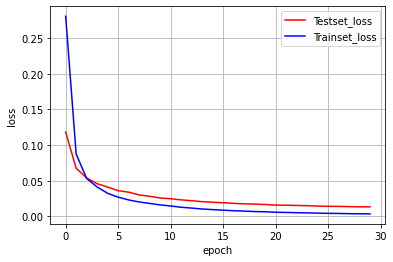

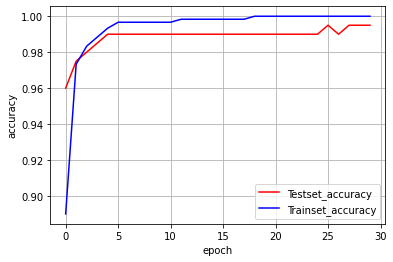

In [13]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, c = 'red', markersize = 3,label = 'Testset_loss')
plt.plot(x_len, y_loss, c = 'blue', markersize = 3,label = 'Trainset_loss')
plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vacc, c = 'red', markersize = 3,label = 'Testset_accuracy')
plt.plot(x_len, y_acc, c = 'blue', markersize = 3,label = 'Trainset_accuracy')
plt.legend(loc = 'lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [14]:
def evaluate_model(model, val_data):
    
    results = model.evaluate(val_data, verbose=0)
    loss = results[0]
    acc = results[1]
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
   
                                                                        


In [15]:
test_generator =  validation_gen.flow_from_directory(test_df,
                                                                target_size=(224,224),
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                shuffle=False,
                                                                )  

Found 200 images belonging to 2 classes.


In [16]:
evaluate_model(res50, test_generator)

    Test Loss: 0.00473
Test Accuracy: 100.00%


In [17]:
yy=res50.predict(test_generator)

In [18]:
test_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [19]:
yy

array([[9.97187912e-01, 2.81206053e-03],
       [9.95031953e-01, 4.96807368e-03],
       [9.99096870e-01, 9.03150765e-04],
       [9.96156752e-01, 3.84331821e-03],
       [9.96750832e-01, 3.24916793e-03],
       [9.90885854e-01, 9.11413599e-03],
       [9.99699831e-01, 3.00171581e-04],
       [9.98989761e-01, 1.01021479e-03],
       [9.93749022e-01, 6.25097333e-03],
       [9.82224524e-01, 1.77755207e-02],
       [9.99574125e-01, 4.25880920e-04],
       [9.90426779e-01, 9.57315601e-03],
       [9.99199927e-01, 8.00073321e-04],
       [9.98347878e-01, 1.65209989e-03],
       [9.99595702e-01, 4.04358754e-04],
       [9.99845028e-01, 1.55001151e-04],
       [9.97274935e-01, 2.72511248e-03],
       [9.98899341e-01, 1.10060931e-03],
       [9.90744650e-01, 9.25534591e-03],
       [9.99530792e-01, 4.69200546e-04],
       [9.66953158e-01, 3.30467634e-02],
       [9.93102312e-01, 6.89766835e-03],
       [9.96770918e-01, 3.22910165e-03],
       [9.97664094e-01, 2.33591837e-03],
       [9.983705

In [20]:
y22=np.argmax(yy,axis=1)

In [21]:
y22

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

**CLASSIFICATION REPORT FOR TESTING SET**

In [22]:
clr = classification_report(test_generator.labels, y22, target_names=["NEGATIVE", "POSITIVE"])
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00       100
    POSITIVE       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [23]:
from sklearn.metrics import confusion_matrix

In [31]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])


True Negatives:  100
False Positives:  0
False Negatives:  0
True Positives:  100


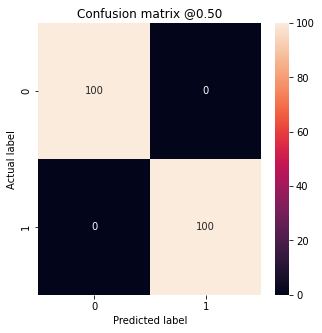

In [32]:
plot_cm(test_generator.labels, y22)
